# COGS 108 - Final Project

# Overview
Explored whether not prioritizing certain yelp reviews and calculating the probaility of past critical evaluations can lead to a relationship being drawn between the two. There is no evident strong relationship between the chance of getting a critical violation and the score they received. Since the relationship wasn't very strong no confident claims could have been drawn

# Name & Github
### Name: Zytal Lenus 
### Github Username: zlenus

# Research Question
Can user data from restaurant review sites such as Yelp crossed with other variable predictive factors, like previous health inspections, help prioritize certain restraunt health inspections?

# Background and Prior Work

   Health care officials are trying to become more effective and efficient at insepcting restaurants in popoulated cities. In Chicago for example they used other variables to help predict whether a restaurant could possibly earn a critical violation (1). Some of the variables they used for predictions are history of critical violations, sanitation complaints,time since last inspection, and more. It was found that using these other variables as a predictive measure health inspectors could have detected other establshments critical violations a motnh in advance.
      
   Similarly anothe predictive measure that coud be used is restaurant rating apps. Yelp, for example, in big cities like Los Angles and San Francisco post health sanitation scores on restaurants pages. An article covers how Yelp teamed up with Socrata in order to link the data from restaurant inspection data to Yelp (2). It was foudn that using Yelp data it can predict the chance of health violation at restaurants.

### References:


- 1) https://datasmart.ash.harvard.edu/news/article/delivering-faster-results-with-food-inspection-forecasting-631
- 2)https://gcn.com/articles/2015/03/02/yelp-city-restaurant-inspections.aspx

# Hypothesis
I believe a crossover of restaurant review sites and judging restaurants probability of earning critical violations can improve the effecctiveness and speed of restuarant health inspections as we would be able to identify which restaurant should be inspected more immedaitely if a relationship is found. Using data collected from reviews of customers and past inspections in real time we can form an algorithm that points inpectiors towards establishments that show a high chance of violating crictical health codes and shut them down ahead of time.


# Dataset(s)
#### Dataset Name: 
The provided dataset of inspections, restaurants, violations, and yelp reviews.
#### Link to the dataset:
That was provided to us.
#### Number of observations:
Before cleaning the data, totaling all the data sets I used there was 81,970 observations (that is totaling each observation from the 4 datasets). But the final combined dataset has 3924 observations. 
#### Description of each Dataset:
##### inspection dataset:
Inspections set had the inofrmation of past reviews on each restaurant. I only kept columns pertaining to general information of the restaurant and focused on having reports of past inspections and their ratings.
##### restaurants dataset:
Restuarant data includes the general information of a restaurant. So if a relationship is found the information for each restaurant can be pulled up easily.
##### violations dataset:
Violations set has information on the severity of the violation. So the data pulled from this set is the general information plus whether it was a critical violation or not.
##### yelp dataset:
Yelp review contained different reviews for yelp users pertaining to the resaurants of that area. I stripped it to only include the score,address, and availabilty of each restaurant.

# Setup

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

from pandas.plotting import scatter_matrix

from sklearn.linear_model import LinearRegression




In [2]:
from zipfile import ZipFile

#'r' means you're opening the zip file in read mode
with ZipFile("data.zip", 'r') as zip: 
    # print contents of the zip file 
    zip.printdir()   
    # extracting the files 
    zip.extractall()
inspec = pd.read_csv("data/inspections.csv")
res= pd.read_csv("data/restaurants.csv")
viol= pd.read_csv("data/violations.csv")
zipc= pd.read_csv("data/zipcodes.csv")
yelp= pd.read_csv("data/yelp.csv")

File Name                                             Modified             Size
data/                                          2020-06-04 17:06:50            0
__MACOSX/._data                                2020-06-04 17:06:50          312
data/inspections.csv                           2020-06-04 16:55:34      7296910
__MACOSX/data/._inspections.csv                2020-06-04 16:55:34          212
data/violations.csv                            2020-06-04 16:55:56     86568133
__MACOSX/data/._violations.csv                 2020-06-04 16:55:56          212
data/yelp.csv                                  2020-06-04 16:56:04       883979
__MACOSX/data/._yelp.csv                       2020-06-04 16:56:04          212
data/zipcodes.csv                              2020-06-04 16:56:16         1767
__MACOSX/data/._zipcodes.csv                   2020-06-04 16:56:16          212
data/restaurants.csv                           2020-06-04 16:55:44       504432
__MACOSX/data/._restaurants.csv         

# Data Cleaning
Before cleaning the data, totaling all the data sets I used there was 81,970 observations. But the final combined dataset has 3924 observations. This of course is much of an imporvement in comparsion to the previous 80000 we had before. Most of the cleanup was making sure all important text was uniform and we can combine the datasets together with the information we needed for our analysis. For the datasets of yelp and inspections I dropped information that had been given a rating of 3+ or scored 90 and above respectively. This is because I wanted to primarily focus on data that had received lower scores as they have received a high score and we want to initally focus on lower scoring restaurants for the test run. The final step of cleaning up was concatenating the data and removing duplicates. Additionally I removed restaurants that had been reported as closed since they were closed and no longer relevant and set up an additional column of data that is explained further down

In [3]:
#to make it more booty-full
def clean_text(string):
    if type(string)==float:
        return string
    else:
        return string.lower()

In [4]:
#include only relevant columns
yelp=yelp[['id','name','is_closed','rating','address1']]

#cleaning up the yelp reviews so we only view ratings that have scored 3 and below
yelp= yelp.drop(yelp.loc[yelp['rating']>3].index)


#cleaning up the text
yelp['name']=yelp['name'].apply(clean_text)
yelp['address1']=yelp['address1'].apply(clean_text)


In [5]:
#include only relevant columns
inspec=inspec[['hsisid', 'date', 'name', 'address1','phonenumber',
        'inspectedby','previous_inspection_date', 'days_since_previous_inspection',
        'score', 'num_critical', 'num_non_critical',]]
#'num_critical_previous','num_non_critical_previous' PREVIOUSLY DELETED DATA???

#dropping scores that exceed a score of 90 and above
inspec= inspec.drop(inspec.loc[inspec['score']>=90].index)


#cleaning up the text
inspec['name']=inspec['name'].apply(clean_text)
inspec['address1']=inspec['address1'].apply(clean_text)
inspec['inspectedby']=inspec['inspectedby'].apply(clean_text)

inspec

,hsisid,date,name,address1,phonenumber,inspectedby,previous_inspection_date,days_since_previous_inspection,score,num_critical,num_non_critical
567,4092015610,2012-11-27T00:00:00Z,waffle house #1302,1417 e williams st,(919) 363-9137,andrea anover,NaN,NaN,89.0,11,7
1205,4092016244,2013-02-01T00:00:00Z,paradise india cuisine,10255 chapel hill rd,(919) 481-6881,thomas jumalon,NaN,NaN,85.0,13,14
1527,4092014324,2013-02-27T00:00:00Z,wang`s kitchen,3631 new bern ave,(919) 212-8805,melissa harrison,NaN,NaN,84.0,13,19
1654,4092016186,2013-03-07T00:00:00Z,back 9 pub,4220 nw cary pky,(919) 462-3550,angela myers,NaN,NaN,87.5,15,14
1803,4092013977,2013-03-19T00:00:00Z,jumbo china #5,6108 falls of neuse rd,(919) 878-9877,tim bass,NaN,NaN,87.0,18,17
...,...,...,...,...,...,...,...,...,...,...,...
18307,4092015244,2016-10-24T00:00:00Z,s-mart cafe,1000 ryan rd,(919) 469-0559,angela myers,2016-08-05T00:00:00Z,80.0,72.5,15,14
18326,4092300245,2016-10-24T00:00:00Z,s-mart meat market,1000 ryan rd,(919) 469-0559,angela myers,2016-08-05T00:00:00Z,80.0,88.5,2,10
18358,4092017012,2016-10-26T00:00:00Z,carolina sushi &amp; roll,5951-107 poyner village pky,(919) 981-5835,lucy schrum,2016-04-20T00:00:00Z,189.0,86.5,10,16
18361,4092017135,2016-10-26T00:00:00Z,east garden,1104 ledsome ln,(919) 322-5558,angela myers,2016-05-26T00:00:00Z,153.0,80.0,10,10


,hsisid,date,name,address1,phonenumber,inspectedby,previous_inspection_date,days_since_previous_inspection,score,num_critical,num_non_critical
567,4092015610,2012-11-27T00:00:00Z,waffle house #1302,1417 e williams st,(919) 363-9137,andrea anover,NaN,NaN,89.0,11,7
1205,4092016244,2013-02-01T00:00:00Z,paradise india cuisine,10255 chapel hill rd,(919) 481-6881,thomas jumalon,NaN,NaN,85.0,13,14
1527,4092014324,2013-02-27T00:00:00Z,wang`s kitchen,3631 new bern ave,(919) 212-8805,melissa harrison,NaN,NaN,84.0,13,19
1654,4092016186,2013-03-07T00:00:00Z,back 9 pub,4220 nw cary pky,(919) 462-3550,angela myers,NaN,NaN,87.5,15,14
1803,4092013977,2013-03-19T00:00:00Z,jumbo china #5,6108 falls of neuse rd,(919) 878-9877,tim bass,NaN,NaN,87.0,18,17
...,...,...,...,...,...,...,...,...,...,...,...
18307,4092015244,2016-10-24T00:00:00Z,s-mart cafe,1000 ryan rd,(919) 469-0559,angela myers,2016-08-05T00:00:00Z,80.0,72.5,15,14
18326,4092300245,2016-10-24T00:00:00Z,s-mart meat market,1000 ryan rd,(919) 469-0559,angela myers,2016-08-05T00:00:00Z,80.0,88.5,2,10
18358,4092017012,2016-10-26T00:00:00Z,carolina sushi &amp; roll,5951-107 poyner village pky,(919) 981-5835,lucy schrum,2016-04-20T00:00:00Z,189.0,86.5,10,16
18361,4092017135,2016-10-26T00:00:00Z,east garden,1104 ledsome ln,(919) 322-5558,angela myers,2016-05-26T00:00:00Z,153.0,80.0,10,10


In [6]:
#include only relevant columns
res= res[['X.objectid', 'hsisid', 'name', 'address1','phonenumber']]

#cleaning up the text
res['name']=res['name'].apply(clean_text)
res['address1']=res['address1'].apply(clean_text)

res

,X.objectid,hsisid,name,address1,phonenumber
0,1001,4092017230,spring cafe 2,2900-104 spring forest rd,(919) 977-3679
1,1002,4092040338,carolina classic hot dogs #2 (wcid #549),309 holloman st,NaN
2,1003,4092014444,taco bell #22798,2207 s main st,(919) 554-4924
3,1004,4092015333,the remedy diner,137 e hargett st,(919) 835-3553
4,1005,4092160069,zebulon house (kitchen),551 pony rd,NaN
...,...,...,...,...,...
3319,2996,4092016658,la roma pizza,1322 fifth ave,(919) 662-1700
3320,2997,4092016663,bojangles #5,3301 s wilmington st,(919) 772-4512
3321,2998,4092016557,burger king #19795,22114 s main st,(919) 556-7773
3322,2999,4092017227,quickly,4141 davis dr,(984) 465-0347


,X.objectid,hsisid,name,address1,phonenumber
0,1001,4092017230,spring cafe 2,2900-104 spring forest rd,(919) 977-3679
1,1002,4092040338,carolina classic hot dogs #2 (wcid #549),309 holloman st,NaN
2,1003,4092014444,taco bell #22798,2207 s main st,(919) 554-4924
3,1004,4092015333,the remedy diner,137 e hargett st,(919) 835-3553
4,1005,4092160069,zebulon house (kitchen),551 pony rd,NaN
...,...,...,...,...,...
3319,2996,4092016658,la roma pizza,1322 fifth ave,(919) 662-1700
3320,2997,4092016663,bojangles #5,3301 s wilmington st,(919) 772-4512
3321,2998,4092016557,burger king #19795,22114 s main st,(919) 556-7773
3322,2999,4092017227,quickly,4141 davis dr,(984) 465-0347


In [7]:
#include only relevant columns
viol= viol[['X.objectid', 'hsisid', 'inspectdate', 'critical','inspectedby']]

#excluding violations that weren't critical
viol= viol.drop(viol.loc[viol['critical']=='No'].index)

#cleaning up the text
viol['inspectedby']=viol['inspectedby'].apply(clean_text)

viol

,X.objectid,hsisid,inspectdate,critical,inspectedby
0,2149,4092015279,2014-09-22T00:00:00.000Z,Yes,lucy schrum
1,2150,4092014572,2014-09-29T00:00:00.000Z,Yes,daryl beasley
2,2151,4092015906,2014-10-01T00:00:00.000Z,Yes,lucy schrum
3,2152,4092013840,2014-10-08T00:00:00.000Z,Yes,lucy schrum
4,2153,4092021788,2014-10-09T00:00:00.000Z,Yes,lucy schrum
...,...,...,...,...,...
189797,2144,4092015549,2014-09-10T00:00:00.000Z,Yes,lucy schrum
189798,2145,4092016135,2014-09-11T00:00:00.000Z,Yes,james smith
189799,2146,4092020997,2014-09-12T00:00:00.000Z,Yes,andrea anover
189800,2147,4092021798,2014-09-19T00:00:00.000Z,Yes,thomas jumalon


,X.objectid,hsisid,inspectdate,critical,inspectedby
0,2149,4092015279,2014-09-22T00:00:00.000Z,Yes,lucy schrum
1,2150,4092014572,2014-09-29T00:00:00.000Z,Yes,daryl beasley
2,2151,4092015906,2014-10-01T00:00:00.000Z,Yes,lucy schrum
3,2152,4092013840,2014-10-08T00:00:00.000Z,Yes,lucy schrum
4,2153,4092021788,2014-10-09T00:00:00.000Z,Yes,lucy schrum
...,...,...,...,...,...
189797,2144,4092015549,2014-09-10T00:00:00.000Z,Yes,lucy schrum
189798,2145,4092016135,2014-09-11T00:00:00.000Z,Yes,james smith
189799,2146,4092020997,2014-09-12T00:00:00.000Z,Yes,andrea anover
189800,2147,4092021798,2014-09-19T00:00:00.000Z,Yes,thomas jumalon


In [8]:
#combine the data into one set
df=pd.concat([inspec,res,viol,yelp],join='outer')

#taking away reviews for restaurants that are closed
df= df.drop(df[(df['is_closed']==True)].index)

#sort out duplicate address and remove them from the data set
df=df.drop_duplicates(subset='address1',keep= 'first')

df= df.dropna(subset=['score'])

df

,X.objectid,address1,critical,date,days_since_previous_inspection,hsisid,id,inspectdate,inspectedby,is_closed,name,num_critical,num_non_critical,phonenumber,previous_inspection_date,rating,score
567,NaN,1417 e williams st,NaN,2012-11-27T00:00:00Z,NaN,4.092016e+09,NaN,NaN,andrea anover,NaN,waffle house #1302,11.0,7.0,(919) 363-9137,NaN,NaN,89.0
1205,NaN,10255 chapel hill rd,NaN,2013-02-01T00:00:00Z,NaN,4.092016e+09,NaN,NaN,thomas jumalon,NaN,paradise india cuisine,13.0,14.0,(919) 481-6881,NaN,NaN,85.0
1527,NaN,3631 new bern ave,NaN,2013-02-27T00:00:00Z,NaN,4.092014e+09,NaN,NaN,melissa harrison,NaN,wang`s kitchen,13.0,19.0,(919) 212-8805,NaN,NaN,84.0
1654,NaN,4220 nw cary pky,NaN,2013-03-07T00:00:00Z,NaN,4.092016e+09,NaN,NaN,angela myers,NaN,back 9 pub,15.0,14.0,(919) 462-3550,NaN,NaN,87.5
1803,NaN,6108 falls of neuse rd,NaN,2013-03-19T00:00:00Z,NaN,4.092014e+09,NaN,NaN,tim bass,NaN,jumbo china #5,18.0,17.0,(919) 878-9877,NaN,NaN,87.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18271,NaN,2304 gorman st,NaN,2016-10-20T00:00:00Z,274.0,4.092015e+09,NaN,NaN,angela myers,NaN,hardee`s #1205,2.0,11.0,(919) 233-8287,2016-01-20T00:00:00Z,NaN,87.5
18293,NaN,220 nottingham dr,NaN,2016-10-21T00:00:00Z,199.0,4.092012e+09,NaN,NaN,angela myers,NaN,kabuki japanese steak house,10.0,8.0,(919) 380-8081,2016-04-05T00:00:00Z,NaN,85.5
18358,NaN,5951-107 poyner village pky,NaN,2016-10-26T00:00:00Z,189.0,4.092017e+09,NaN,NaN,lucy schrum,NaN,carolina sushi &amp; roll,10.0,16.0,(919) 981-5835,2016-04-20T00:00:00Z,NaN,86.5
18361,NaN,1104 ledsome ln,NaN,2016-10-26T00:00:00Z,153.0,4.092017e+09,NaN,NaN,angela myers,NaN,east garden,10.0,10.0,(919) 322-5558,2016-05-26T00:00:00Z,NaN,80.0


,X.objectid,address1,critical,date,days_since_previous_inspection,hsisid,id,inspectdate,inspectedby,is_closed,name,num_critical,num_non_critical,phonenumber,previous_inspection_date,rating,score
567,NaN,1417 e williams st,NaN,2012-11-27T00:00:00Z,NaN,4.092016e+09,NaN,NaN,andrea anover,NaN,waffle house #1302,11.0,7.0,(919) 363-9137,NaN,NaN,89.0
1205,NaN,10255 chapel hill rd,NaN,2013-02-01T00:00:00Z,NaN,4.092016e+09,NaN,NaN,thomas jumalon,NaN,paradise india cuisine,13.0,14.0,(919) 481-6881,NaN,NaN,85.0
1527,NaN,3631 new bern ave,NaN,2013-02-27T00:00:00Z,NaN,4.092014e+09,NaN,NaN,melissa harrison,NaN,wang`s kitchen,13.0,19.0,(919) 212-8805,NaN,NaN,84.0
1654,NaN,4220 nw cary pky,NaN,2013-03-07T00:00:00Z,NaN,4.092016e+09,NaN,NaN,angela myers,NaN,back 9 pub,15.0,14.0,(919) 462-3550,NaN,NaN,87.5
1803,NaN,6108 falls of neuse rd,NaN,2013-03-19T00:00:00Z,NaN,4.092014e+09,NaN,NaN,tim bass,NaN,jumbo china #5,18.0,17.0,(919) 878-9877,NaN,NaN,87.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18271,NaN,2304 gorman st,NaN,2016-10-20T00:00:00Z,274.0,4.092015e+09,NaN,NaN,angela myers,NaN,hardee`s #1205,2.0,11.0,(919) 233-8287,2016-01-20T00:00:00Z,NaN,87.5
18293,NaN,220 nottingham dr,NaN,2016-10-21T00:00:00Z,199.0,4.092012e+09,NaN,NaN,angela myers,NaN,kabuki japanese steak house,10.0,8.0,(919) 380-8081,2016-04-05T00:00:00Z,NaN,85.5
18358,NaN,5951-107 poyner village pky,NaN,2016-10-26T00:00:00Z,189.0,4.092017e+09,NaN,NaN,lucy schrum,NaN,carolina sushi &amp; roll,10.0,16.0,(919) 981-5835,2016-04-20T00:00:00Z,NaN,86.5
18361,NaN,1104 ledsome ln,NaN,2016-10-26T00:00:00Z,153.0,4.092017e+09,NaN,NaN,angela myers,NaN,east garden,10.0,10.0,(919) 322-5558,2016-05-26T00:00:00Z,NaN,80.0


# Data Analysis and Results
The sorting of data and use of Yelp data helps prioritize what restaurants to observe. We are able to drop restaurants that scored above the average score of 3 of yelp (as that is considered to be passing/adequate). This helped condense the data to focus on restaurants that have been reviewed as bad. From here we sort out the data once more and condense it some more.

In [9]:
df.columns

Index(['X.objectid', 'address1', 'critical', 'date',
       'days_since_previous_inspection', 'hsisid', 'id', 'inspectdate',
       'inspectedby', 'is_closed', 'name', 'num_critical', 'num_non_critical',
       'phonenumber', 'previous_inspection_date', 'rating', 'score'],
      dtype='object')

Index(['X.objectid', 'address1', 'critical', 'date',
       'days_since_previous_inspection', 'hsisid', 'id', 'inspectdate',
       'inspectedby', 'is_closed', 'name', 'num_critical', 'num_non_critical',
       'phonenumber', 'previous_inspection_date', 'rating', 'score'],
      dtype='object')

In [10]:
df['percentofcritical']= pd.DataFrame((df['num_critical']/(df['num_critical']+df['num_non_critical'])*100))
df.sort_values(by=['score'], inplace=True, ascending=False)
df

,X.objectid,address1,critical,date,days_since_previous_inspection,hsisid,id,inspectdate,inspectedby,is_closed,name,num_critical,num_non_critical,phonenumber,previous_inspection_date,rating,score,percentofcritical
13167,NaN,321 s salem st,NaN,2015-10-27T00:00:00Z,279.0,4.092022e+09,NaN,NaN,karla crowder,NaN,hunt brothers pizza,10.0,4.0,(919) 362-7134,2015-01-21T00:00:00Z,NaN,89.5,71.428571
10946,NaN,1150 beaver creek commons dr,NaN,2015-05-21T00:00:00Z,491.0,4.092015e+09,NaN,NaN,karla crowder,NaN,ihop #3181,7.0,8.0,(919) 387-8147,2014-01-15T00:00:00Z,NaN,89.5,46.666667
5854,NaN,2400 spring forest rd,NaN,2014-03-27T00:00:00Z,279.0,4.092014e+09,NaN,NaN,christy klaus,NaN,circle k #6329,5.0,8.0,(919) 875-0618,2013-06-21T00:00:00Z,NaN,89.5,38.461538
18176,NaN,2700 regency pky,NaN,2016-10-13T00:00:00Z,174.0,4.092016e+09,NaN,NaN,karla crowder,NaN,capi's,8.0,7.0,(919) 468-0084,2016-04-22T00:00:00Z,NaN,89.5,53.333333
10875,NaN,126 n salem st,NaN,2015-05-18T00:00:00Z,221.0,4.092014e+09,NaN,NaN,karla crowder,NaN,peak city grill & bar,8.0,9.0,(919) 303-8001,2014-10-09T00:00:00Z,NaN,89.5,47.058824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17535,NaN,5563 western blvd,NaN,2016-08-26T00:00:00Z,78.0,4.092014e+09,NaN,NaN,angela myers,NaN,hong kong chinese kitchen,10.0,11.0,(919) 851-1505,2016-06-09T00:00:00Z,NaN,79.0,47.619048
8253,NaN,6204-120 glenwood ave,NaN,2014-10-28T00:00:00Z,182.0,4.092016e+09,NaN,NaN,angela myers,NaN,sawasdee thai restaurant,9.0,13.0,(919) 781-7599,2014-04-29T00:00:00Z,NaN,78.5,40.909091
4372,NaN,5800 duraleigh rd,NaN,2013-11-01T00:00:00Z,297.0,4.092014e+09,NaN,NaN,angela myers,NaN,chinatown express,17.0,17.0,NaN,2013-01-08T00:00:00Z,NaN,77.5,50.000000
16721,NaN,6105 grace park dr,NaN,2016-06-24T00:00:00Z,NaN,4.092017e+09,NaN,NaN,thomas jumalon,NaN,spice &amp; curry,12.0,23.0,(919) 234-6281,NaN,NaN,76.0,34.285714


,X.objectid,address1,critical,date,days_since_previous_inspection,hsisid,id,inspectdate,inspectedby,is_closed,name,num_critical,num_non_critical,phonenumber,previous_inspection_date,rating,score,percentofcritical
13167,NaN,321 s salem st,NaN,2015-10-27T00:00:00Z,279.0,4.092022e+09,NaN,NaN,karla crowder,NaN,hunt brothers pizza,10.0,4.0,(919) 362-7134,2015-01-21T00:00:00Z,NaN,89.5,71.428571
10946,NaN,1150 beaver creek commons dr,NaN,2015-05-21T00:00:00Z,491.0,4.092015e+09,NaN,NaN,karla crowder,NaN,ihop #3181,7.0,8.0,(919) 387-8147,2014-01-15T00:00:00Z,NaN,89.5,46.666667
5854,NaN,2400 spring forest rd,NaN,2014-03-27T00:00:00Z,279.0,4.092014e+09,NaN,NaN,christy klaus,NaN,circle k #6329,5.0,8.0,(919) 875-0618,2013-06-21T00:00:00Z,NaN,89.5,38.461538
18176,NaN,2700 regency pky,NaN,2016-10-13T00:00:00Z,174.0,4.092016e+09,NaN,NaN,karla crowder,NaN,capi's,8.0,7.0,(919) 468-0084,2016-04-22T00:00:00Z,NaN,89.5,53.333333
10875,NaN,126 n salem st,NaN,2015-05-18T00:00:00Z,221.0,4.092014e+09,NaN,NaN,karla crowder,NaN,peak city grill & bar,8.0,9.0,(919) 303-8001,2014-10-09T00:00:00Z,NaN,89.5,47.058824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17535,NaN,5563 western blvd,NaN,2016-08-26T00:00:00Z,78.0,4.092014e+09,NaN,NaN,angela myers,NaN,hong kong chinese kitchen,10.0,11.0,(919) 851-1505,2016-06-09T00:00:00Z,NaN,79.0,47.619048
8253,NaN,6204-120 glenwood ave,NaN,2014-10-28T00:00:00Z,182.0,4.092016e+09,NaN,NaN,angela myers,NaN,sawasdee thai restaurant,9.0,13.0,(919) 781-7599,2014-04-29T00:00:00Z,NaN,78.5,40.909091
4372,NaN,5800 duraleigh rd,NaN,2013-11-01T00:00:00Z,297.0,4.092014e+09,NaN,NaN,angela myers,NaN,chinatown express,17.0,17.0,NaN,2013-01-08T00:00:00Z,NaN,77.5,50.000000
16721,NaN,6105 grace park dr,NaN,2016-06-24T00:00:00Z,NaN,4.092017e+09,NaN,NaN,thomas jumalon,NaN,spice &amp; curry,12.0,23.0,(919) 234-6281,NaN,NaN,76.0,34.285714


### New DataFrame with column 'percentofcritical'
Creating a seperate dataframe that includes column 'percentofcritical' which includes what we want to compare. This column is a calculatin of the total number of critical evaluations divided the total number of evaluations (including both critical and noncritical evaluations); thus showing the probability of a restaurant getting a critical violation. I want to create grpahs comparing where the probability of getting a critical evaluation aligns with the current score the restaurant received. If there is a relationship it can suggest that those who have a higher probability of critical evaluations will tend to get a low score since low scores corresponds with negative inspections.

In [11]:
predgraph= pd.DataFrame()

#predgraph['percentofcritical']= df['percentofcritical']
predgraph['score']= df['score']
predgraph['percentofcritical']= df['percentofcritical']

predgraph

,score,percentofcritical
13167,89.5,71.428571
10946,89.5,46.666667
5854,89.5,38.461538
18176,89.5,53.333333
10875,89.5,47.058824
...,...,...
17535,79.0,47.619048
8253,78.5,40.909091
4372,77.5,50.000000
16721,76.0,34.285714


,score,percentofcritical
13167,89.5,71.428571
10946,89.5,46.666667
5854,89.5,38.461538
18176,89.5,53.333333
10875,89.5,47.058824
...,...,...
17535,79.0,47.619048
8253,78.5,40.909091
4372,77.5,50.000000
16721,76.0,34.285714


Trying to determine how to graph the next step. Whether the graph should be a histogram or scatterplot.

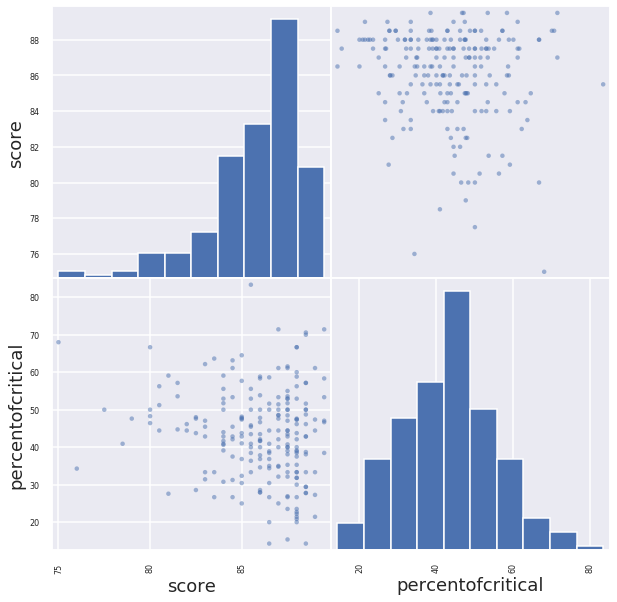

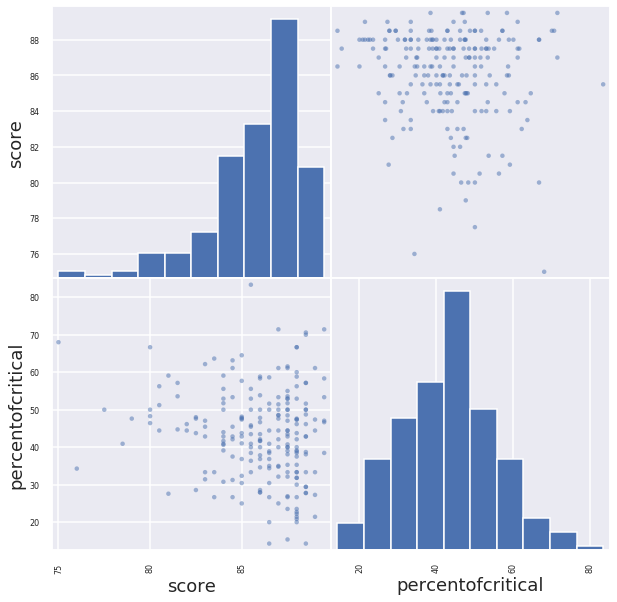

In [12]:
scatter_matrix(predgraph,figsize=(10,10))

f4 = plt.gcf()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7ca168d668>,
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7ca168d668>,
      dtype=object)

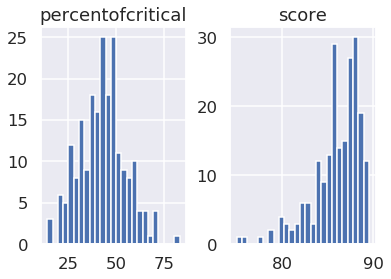

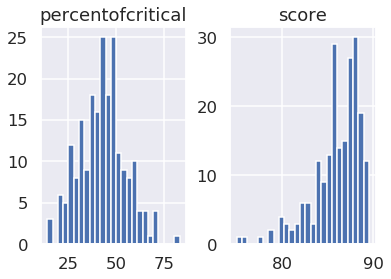

In [13]:
predgraph.hist(bins=25)

Initally I thought a histogram would reflect it well but I realized that a scatter plot would enable me to plot the a line of regression to see if there was a relationship of some sort. But the data wasn't visually that appealing and it made a scatterplot seem more better.

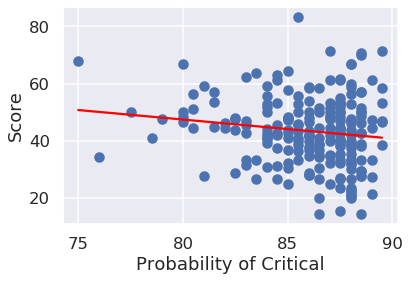

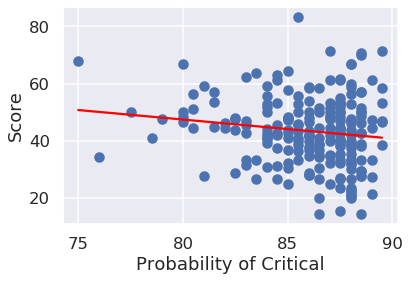

In [14]:
X = predgraph.iloc[:, 0].values.reshape(-1, 1)
Y = predgraph.iloc[:, 1].values.reshape(-1, 1) 
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.ylabel('Score')
plt.xlabel('Probability of Critical')
plt.show()

The evidence from the above doesn't really suggest any sort of STRONG relation between the two variables. There really is no strong correlation that points out whether a higher probability of getting a critical error corresponds with the score from their evaluation. There is a slight tilt for the line of regression that shows a negative relationship but we can most likely assume that this is due to few outliers in the data. 

We can observe that data heavily congregates towards the right side of the graph (towards a high probability of getting a critical violation). But along the y-axis there is no obvious pattern as the data is dispersed throughout it. There is a slight relationship that the higher the chance of critical the higher they score but that is solely based on the very slight tilt of the line of regression.


# Ethics and Privacy


The data collection will only be taken from indivduals who consent to having their information to be used and collected. Obviously giving them the oppurtunity to revoke their information at anytime as well. A potential bias could be inaccurate reviews that have been purposely left in order to sway the algorithm to purposely bias the data. A way to combat this would to ensure that the participants we pull data from are users how are approved to not be robots. That can be done through making the users go through those quick robot checks just to ensure that no bots are being used to overthrow the rating systems.

# Conclusion and Discussion

   While the factoring of yelp reviews were somewhat beneficial as we were able to sort the dataset out to only include bad reviews the main factors of the hypothesis didn't prove to have any effects. i calculated the probability of a restaurant receiving a critical violation and compared it to the score the received according to the inspection they received to see if there was any correlation. From the graph we can see that there was no evident suggest of any kind of relationship. The plotted data didn't really show any clear concise pattern so we can't assume my hypothesis to be accurate so it must be rejected.
   
Of course there were limitations as the dataset is limiting in itself. I primarily focused on data that had been scored more low in efforts to be able distinguish a pattern in low performing restaurants. Also since I didn't analyze other variables that is a limitation as it doesn't allow for a full in depth analysis. There are multiple other relationships that could have been analyzed but the one I chose just happened to not prove my hypothesis to be true. Another limitation was missing data for some restuarant as they were removed for the data set during cleanup. For instance some restaurants had missing inspection scores or didn't have information pertaining to their last inspection. Those kinds of data weren't factored into this data but if they were those could be seen as pointers of places that need to be inspected just so that we have data on them.

It's important that this kind of study continues as it is important  for the public safety. If a pattern is able to be establish when it comes to health inspections it could help keep the city health and avoid food related sickness. Identifying restaurants that could possibly be endangering the publics health helps reduce illness and helps restaurants identify problem areas. To some degree I still do believe that past inspections can prove to be a useful tool when trying to predict what restaurant need to undergo inspection before others.
